In [1]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from spectral_cube import SpectralCube
#from regions import Regions
#%matplotlib widget
home = os.path.expanduser("~")
#from kd import kd_utils
import argparse
import scipy.optimize as opt
from astropy import units
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D


In [2]:
def smooth(x,window_len=3,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='same')

    return y[window_len-1:window_len-1+len(x)]

from scipy import optimize
from scipy import signal

# FWHM = 2*(2ln2)^0.5*sigma=2.35482*sigma

def gaussian(x,a,b,c): 
    return a*np.exp(-0.5*((x-b)/c)**2)

def fit_gaussians(xdata, ydata, N=1):
    '''
    Inputs:
        xdata: x-axis of spectrum, veleocity or frequency
        ydata: y-axis of spectrum, the power or intensity
    Keywords:
        N: the number of Gaussian peaks to fit, default is 1.
    Returns:
        fitting parameters: pfit = (Ipeak, Vpeak, FWHM)
        fitting errors: efit = (Error_Ip, Error_Vp, Error_FWHM)
        fitting function: yfit=fitfunc(pfit,xdata)
        error function: rms=np.std(errfunc(pfit,xdata,ydata)
        reduced chi-sq: redchisq
    '''

    nbins = len(xdata)
    imax = np.argmax(ydata)
    pinit = np.array([ydata[imax],xdata[imax],0.001*nbins])

# perform this fit iteratively
    for n in range(1,N+1): 
        def fitfunc(p,x):
            retval = np.zeros(len(x))
            for i in range(n):
                retval += gaussian(x,p[3*i],p[3*i+1],p[3*i+2])
            return retval
        def errfunc(p,x,y):
            return y - fitfunc(p,x)

        out = optimize.leastsq(errfunc,pinit,args=(xdata,ydata),full_output=True)
        if n == N:
           break
# Re-define initial conditions for next round
        pfit = out[0]
        resids = ydata-fitfunc(pfit,xdata)
        imax = np.argmax(resids)
        pinitprime = np.array([resids[imax],xdata[imax],0.001*nbins])
        pinit = np.concatenate((pfit,pinitprime))

    redchisq = (errfunc(out[0],xdata,ydata)**2).sum()/(len(ydata)-len(pinit)-1) #-1 included here!
    rms = np.std(errfunc(out[0],xdata,ydata))
    redchisq = redchisq/rms**2
    return out[0],out[1],fitfunc,errfunc,redchisq


In [4]:
file_in = home +'/data/'+'G34.25+0.14.fits'

hdu = fits.open(file_in)

hdu.info()

hdu[0].header
#data = hdu[0].data
#print (data.shape)

Filename: /home/lxwang/data/G34.25+0.14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      84   (40, 39, 1600)   float64   


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                   40                                                  
NAXIS2  =                   39                                                  
NAXIS3  =                 1600                                                  
OBJECT  = 'G034.39+00.22'                                                       
TELESCOP= 'FAST    '                                                            
INSTRUME= 'MBSPEC  '                                                            
OBSERVER= 'Unknown Observer'                                                    
DATE-MAP= '2020-08-21T01:48:39' / Created by fastgridder                        
DATE    = '2020-08-21'                                                          
OBSRA   =                283

生成moment0图像

In [7]:
sc = SpectralCube.read(file_in)
#print(sc)

moment_0 = sc.moment(order=0)
moment_0.write('moment1.fits')  
moment_0.hdu  

In [8]:
file_in = home +'/test/'+'moment0.fits'

hdu = fits.open(file_in)

hdu.info()

#hdu[0].header
data = hdu[0].data
print (data.shape)

Filename: /home/lxwang/test/moment0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      83   (40, 39)   float64   
(39, 40)


In [9]:
file_in = home +'/test/'+'moment0.fits'

hdu = fits.open(file_in)

hdu.info()

hdu[0].header
data = hdu[0].data

print (data.shape)

Filename: /home/lxwang/test/moment0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      83   (40, 39)   float64   
(39, 40)


In [10]:
import argparse
import numpy as np
import scipy.optimize as opt
from astropy import units
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D

import matplotlib.pyplot as plt

#def load_image(filein):

hdul = fits.open(file_in,'readonly')
wcs = WCS(hdul[0].header)
img = np.squeeze(hdul[0].data)
hdul.close()
#return img, wcs


def Gaussian2d(xydata, xo, yo, sigma_X, sigma_Y, amplitude, theta, offset0, offset1, u, v):
    
    (x,y) = xydata
    xo = float(xo)
    yo = float(yo)    
#g = offset0 + offset1*(x+u)*(y+v) +  amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    a = (np.cos(theta)**2)/(2*sigma_X**2) + (np.sin(theta)**2)/(2*sigma_Y**2)
    b = -(np.sin(2*theta))/(4*sigma_X**2) + (np.sin(2*theta))/(4*sigma_Y**2)
    c = (np.sin(theta)**2)/(2*sigma_X**2) + (np.cos(theta)**2)/(2*sigma_Y**2)
    g = offset0 + offset1*(x-u)*(y-v) + \
    amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
#    return g.ravel()

def Gaussian2dFit(img,radius_x=10,radius_y=10):
   
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, theta, offset0, offset1, u, v
    initial_guess = (img.shape[1]/2,img.shape[0]/2,radius_x,radius_y,img.max(),0,0,0,0,0.0)
    popt, pcov = opt.curve_fit(Gaussian2d, (x, y), 
                               img.ravel(), p0=initial_guess)
    xcenter, ycenter, sigmaX, sigmaY, amp, offset0, offset1, theta, u, v = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7], popt[8], popt[9]
    FWHM_X = sigmaX*np.sqrt(8.0*np.log(2.0))
    FWHM_Y = sigmaY*np.sqrt(8.0*np.log(2.0))
    results = (amp,xcenter,ycenter,FWHM_X,FWHM_Y,theta,offset0,offset1,u,v)
    #return results

#def main(args):
    img, wcs = load_image(args.file_fits)
    pos = SkyCoord(args.coor, frame='icrs')
    size = (args.rx*units.arcmin,args.ry*units.arcmin)

    img_cut = Cutout2D(img,position=pos,size=size,wcs=wcs)
#    plt.imshow(img_cut.data,origin='lower')
#    plt.show()
    (Amp,xcenter,ycenter,FWHM_x,FWHM_y,theta,offset0,offset1,u,v) = Gaussian2dFit(img_cut.data)
#    coor = pixel_to_skycoord(xcenter,ycenter,img_cut.wcs)
#    coor_xw = pixel_to_skycoord(xcenter-FWHM_x/2,ycenter,img_cut.wcs)
#    coor_yw = pixel_to_skycoord(xcenter,ycenter-FWHM_y/2,img_cut.wcs)
#    sep_x = coor.separation(coor_xw)
#    sep_y = coor.separation(coor_yw)
    #print("Peak Flux: {:8.4f}\nOffset: {:8.4f}\nX Size: {:6.2f} arcmin\nY Size: {:6.2f} arcmin\nRotation theta: {:8.4f} deg".format(Amp,offset0,FWHM_x*np.abs(wcs.wcs.cdelt[1]*60), FWHM_y*np.abs(wcs.wcs.cdelt[1]*60),np.rad2deg(theta)))

#print("Source Center: ", coor.to_string(style='hmsdms'))
print("Source Center: ")
#print("X size:", sep_x*2)
print("X size:")
#print("Y size:", sep_y*2)
print("Y size:")
   # print("Peak Flux: {:8.4f}\nOffset: {:8.4f}\nRotation theta: {:8.4f} deg".format(Amp,offset0,np.rad2deg(theta)))

Source Center: 
X size:
Y size:


In [11]:
def load_image(filein):

    hdul = fits.open(args.file_fits,'readonly')
    wcs = WCS(hdul[0].header)
    img = np.squeeze(hdul[0].data)
    hdul.close()
    return img, wcs


def Gaussian2d(xydata, xo, yo, sigma_X, sigma_Y, amplitude, theta, offset0, offset1, u, v):
    """Function to fit, returns 2D gaussian function as 1D array
    https://en.wikipedia.org/wiki/Gaussian_function
    https://cran.r-project.org/web/packages/gaussplotR/vignettes/formulas-used-by-fit-gaussian-2D.html
    """

    (x,y) = xydata
    xo = float(xo)
    yo = float(yo)    
    #g = offset0 + offset1*(x+u)*(y+v) +  amplitude*np.exp( - (((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    a = (np.cos(theta)**2)/(2*sigma_X**2) + (np.sin(theta)**2)/(2*sigma_Y**2)
    b = -(np.sin(2*theta))/(4*sigma_X**2) + (np.sin(2*theta))/(4*sigma_Y**2)
    c = (np.sin(theta)**2)/(2*sigma_X**2) + (np.cos(theta)**2)/(2*sigma_Y**2)
    g = offset0 + offset1*(x-u)*(y-v) + \
        amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def Gaussian2dFit(img,radius_x=10,radius_y=10):
    """
    Parameter:
        img - image as numpy array
    """
    x = np.linspace(0, img.shape[1], img.shape[1])
    y = np.linspace(0, img.shape[0], img.shape[0])
    x, y = np.meshgrid(x, y)
    #Parameters: xpos, ypos, sigmaX, sigmaY, amp, theta, offset0, offset1, u, v
    initial_guess = (img.shape[1]/2,img.shape[0]/2,radius_x,radius_y,img.max(),0,0,0,0,0.0)
    popt, pcov = opt.curve_fit(Gaussian2d, (x, y), 
                               img.ravel(), p0=initial_guess)
    xcenter, ycenter, sigmaX, sigmaY, amp, offset0, offset1, theta, u, v = popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6], popt[7], popt[8], popt[9]
    FWHM_X = sigmaX*np.sqrt(8.0*np.log(2.0))
    FWHM_Y = sigmaY*np.sqrt(8.0*np.log(2.0))
    results = (amp,xcenter,ycenter,FWHM_X,FWHM_Y,theta,offset0,offset1,u,v)
    return results


In [ ]:
file_fits = #wenjian
coor0 = 
rx = 
ry = 
img, wcs = load_image(file_fits)
pos = SkyCoord(coor0, frame='icrs')
size = (rx*units.arcmin,ry*units.arcmin)

img_cut = Cutout2D(img,position=pos,size=size,wcs=wcs)
#    plt.imshow(img_cut.data,origin='lower')
#    plt.show()
(Amp,xcenter,ycenter,FWHM_x,FWHM_y,theta,offset0,offset1,u,v) = Gaussian2dFit(img_cut.data)
coor = pixel_to_skycoord(xcenter,ycenter,img_cut.wcs)
coor_xw = pixel_to_skycoord(xcenter-FWHM_x/2,ycenter,img_cut.wcs)
coor_yw = pixel_to_skycoord(xcenter,ycenter-FWHM_y/2,img_cut.wcs)
sep_x = coor.separation(coor_xw)
sep_y = coor.separation(coor_yw)
#print("Peak Flux: {:8.4f}\nOffset: {:8.4f}\nX Size: {:6.2f} arcmin\nY Size: {:6.2f} arcmin\nRotation theta: {:8.4f} deg".format(Amp,offset0,FWHM_x*np.abs(wcs.wcs.cdelt[1]*60), FWHM_y*np.abs(wcs.wcs.cdelt[1]*60),np.rad2deg(theta)))

print("Source Center: ", coor.to_string(style='hmsdms'))
print("X size:", sep_x*2)
print("Y size:", sep_y*2)
print("Peak Flux: {:8.4f}\nOffset: {:8.4f}\nRotation theta: {:8.4f} deg".format(Amp,offset0,np.rad2deg(theta)))


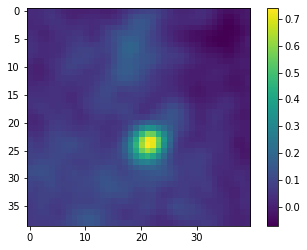

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(data)
plt.colorbar()
#plt.gcf().clear()
#plt.hist(data, bins=10,orientation='horizontal' )
#plt.show()

NameError: name 'fitgaussian' is not defined

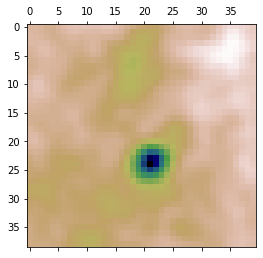

In [ ]:


plt.matshow(data, cmap=plt.cm.gist_earth_r)

params = fitgaussian(data)
fit = gaussian(*params)

plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.copper)
ax = plt.gca()
(height, x, y, width_x, width_y) = params

plt.text(0.95, 0.05, """
x : %.1f
y : %.1f
width_x : %.1f
width_y : %.1f""" %(x, y, width_x, width_y),
        fontsize=16, horizontalalignment='right',
        verticalalignment='bottom', transform=ax.transAxes)

In [ ]:
from scipy import optimize
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

一维拟合（平均）

In [ ]:
import os, sys, argparse,warnings
from spectral_cube import SpectralCube
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from regions import Regions
from astropy.io import ascii
import pyrrl
#import fastspec as fsp
#from smooth import smooth
#from gauss_fit import fit_gaussians
def load_csv(file_csv):
    import csv
    catalog=[]
    with open(file_csv,'rt') as fcsv:
        reader = csv.DictReader(fcsv)
        for row in reader:
            catalog.append({'GName':row['GName'],'GLon':float(row['GLon']),'GLat':float(row['GLat'])})
    return catalog


def plot_spec(velo,spec,plottype='step',vmin=-200,vmax=200,linestyle='solid',fontsize='xx-large',ylabel='Flux [mJy]',color='k'):
    if plottype == 'line':
        plt.plot(velo,spec,linestyle=linestyle,color=color,linewidth=1.5)
    elif plottype == 'step':
        plt.step(velo,spec,linestyle=linestyle,color=color,linewidth=1.5)
    else:
        return 0
    if vmin is not None and vmax is not None:
        plt.xlim([vmin,vmax])
    plt.xlabel('LSR Velocity [km$\,$s$^{-1}$]',fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize) #which='minor' 

    return 0

def main():

#    catalog = load_csv(args.file_cata)
    nlist = np.arange(165,184)
    pixel = 1
    beam = 4.7
    k_b2p = pixel**2 / (np.pi*(beam/2)**2)
    lon = 34.24558
    lat = 0.14079
    radius = 1
    region_str =  'fk5; ellipse(18:53:20.88,+1:15:13.81,144.615",170.44",0.003)'
    #region_str = 'galactic; circle({l:f},{b:f},{r:f}'.format(l=lon,b=lat,r=radius/60.)
    region = Regions.parse(region_str,format='ds9')
    name = 'G{l:5.2f}{b:+05.2f}'.format(l=lon,b=lat)

    c3 = SpectralCube.read('/home/lxwang/Pictures/'+'G34.25+0.14.fits')
    s3 = c3.subcube_from_regions(region)
    d3 = s3.unmasked_data[:,:,:] 
    v = c3.spectral_axis.value
    sm_len = 5
    sp3 = smooth(d3.mean(axis=(1,2)),window_len=sm_len)
    sp3 = sp3.value
    warnings.simplefilter('ignore',UserWarning,lineno=0)
    rest_freq0 = pyrrl.calc.recombination_line_frequency(184,delta=1,element='H',unit=1e6)
    unit = 'Jy'
    if unit == 'Jy':
        ylabel = 'Flux [Jy$\,$beam$^{-1}$]'
    elif unit == 'K':
        ylabel = 'T$_a$ [K]'
    else:
        ylabel = 'Intensity'
    
    vmin = None
    vmax = None
    plot_spec(v,sp3,plottype="line",\
              fontsize=14,vmin=vmin,vmax=vmax,\
              ylabel='ylabel',color='k',linestyle='dashed')
    print(type(sp3),type(v))
    a1,a2,a3,a4,a5=fit_gaussians(v,sp3,N=1)
    print(a1)
    print(a2)
    yfit=a3(a1,v)
    plt.plot(v,sp3)
    plt.plot(v,yfit)
    plt.show()
    if False:
        plt.tight_layout()
        plt.savefig(fileout,format=fext,dpi=300)
       

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[1.77851747e-02 5.22274516e+01 1.08274395e+01]
[[ 3.90797863e-02  1.13256599e-06 -1.58613854e+01]
 [ 1.13256599e-06  1.93130701e+04 -6.89159785e-04]
 [-1.58613854e+01 -6.89159785e-04  1.93130701e+04]]


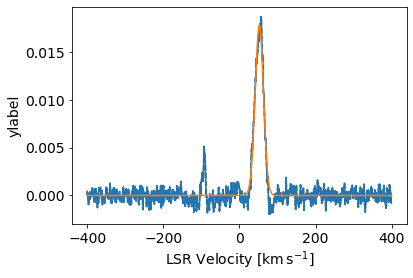

In [ ]:

main()



moment0源坐标转换

In [ ]:
from astropy.wcs import WCS
w = WCS('/home/lxwang/Pictures/G34.25+0.14_v.-400.0.400.0_moment0.fits')

px, py = w.wcs_world2pix(283.337, 1.253, 1)
print(px, py)

22.77479204229735 25.179999999998486


单条谱线拟合

(1600,)
[9.59606075e-03 5.36408402e+01 9.60417087e+00]
[[ 4.40564059e-02  2.44470355e-06 -2.93975247e+01]
 [ 2.44470355e-06  5.88482728e+04 -2.45190025e-03]
 [-2.93975247e+01 -2.45190025e-03  5.88482733e+04]]


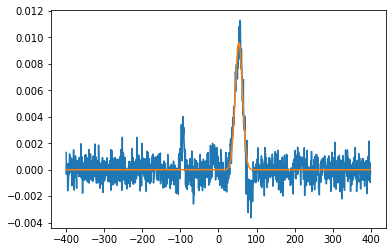

In [ ]:
#from gauss_fit import fit_gaussians
file_in = '/home/lxwang/data/G34.25+0.14.fits'

hdu = fits.open(file_in)

data = hdu[0].data
spec = data[:,23,25]
print(spec.shape)
#spec_ave = np.mean(spec,(1,2))
x= np.arange(-400,400,0.5)
ra=str(data[0])
dec=str(data[1])
#plt.plot(x,spec) 

a1,a2,a3,a4,a5=fit_gaussians(x,spec,N=1)
print(a1)
print(a2)
yfit=a3(a1,x)
plt.plot(x,spec)
plt.plot(x,yfit)
plt.show()

利用脚本一维拟合

In [ ]:
import os, sys, argparse,warnings
from spectral_cube import SpectralCube
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from regions import Regions
from astropy.io import ascii
import pyrrl
#import fastspec as fsp
#from smooth import smooth
#from gauss_fit import fit_gaussians
def load_csv(file_csv):
    import csv
    catalog=[]
    with open(file_csv,'rt') as fcsv:
        reader = csv.DictReader(fcsv)
        for row in reader:
            catalog.append({'GName':row['GName'],'GLon':float(row['GLon']),'GLat':float(row['GLat'])})
    return catalog


def plot_spec(velo,spec,plottype='step',vmin=-200,vmax=200,linestyle='solid',fontsize='xx-large',ylabel='T$_a$ [K]',color='k'):
    if plottype == 'line':
        plt.plot(velo,spec,linestyle=linestyle,color=color,linewidth=1.5)
    elif plottype == 'step':
        plt.step(velo,spec,linestyle=linestyle,color=color,linewidth=1.5)
    else:
        return 0
    if vmin is not None and vmax is not None:
        plt.xlim([vmin,vmax])
    plt.xlabel('LSR Velocity [km$\,$s$^{-1}$]',fontsize=fontsize)
    plt.ylabel(ylabel,fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize) #which='minor' 

    return 0

def main():

#    catalog = load_csv(args.file_cata)
    nlist = np.arange(165,184)
    pixel = 1
    beam = 4.7
    k_b2p = pixel**2 / (np.pi*(beam/2)**2)
    lon = 34.24558
    lat = 0.14079
    radius = 1
    region_str =  'fk5; ellipse(18:53:20.88,+1:15:13.81,144.615",170.44",0.003)'
    #region_str = 'galactic; circle({l:f},{b:f},{r:f}'.format(l=lon,b=lat,r=radius/60.)
    region = Regions.parse(region_str,format='ds9')
    name = 'G{l:5.2f}{b:+05.2f}'.format(l=lon,b=lat)

    c3 = SpectralCube.read('/home/lxwang/data/'+'G34.25+0.14.fits')
    s3 = c3.subcube_from_regions(region)
    d3 = s3.unmasked_data[:,:,:] 
    v = c3.spectral_axis.value
    sm_len = 5
    sp3 = smooth(d3.mean(axis=(1,2)),window_len=sm_len)
    sp3 = sp3.value
    warnings.simplefilter('ignore',UserWarning,lineno=0)
    rest_freq0 = pyrrl.calc.recombination_line_frequency(184,delta=1,element='H',unit=1e6)
    unit = 'K'
    if unit == 'Jy':
        ylabel = 'Flux [Jy$\,$beam$^{-1}$]'
    elif unit == 'K':
        ylabel = 'T$_a$ [K]'
    else:
        ylabel = 'Intensity'
    
    vmin = None
    vmax = None
    plot_spec(v,sp3,plottype="line",\
              fontsize=14,vmin=vmin,vmax=vmax,\
              ylabel='ylabel',color='k',linestyle='dashed')
    print(type(sp3),type(v))
    a1,a2,a3,a4,a5=fit_gaussians(v,sp3,N=1)
    print(a1)
    print(a2)
    yfit=a3(a1,v)
    plt.plot(v,sp3)
    plt.plot(v,yfit)
    plt.show()
    if False:
        plt.tight_layout()
        plt.savefig(fileout,format=fext,dpi=300)
       

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[1.77851747e-02 5.22274516e+01 1.08274395e+01]
[[ 3.90797863e-02  1.13256599e-06 -1.58613854e+01]
 [ 1.13256599e-06  1.93130701e+04 -6.89159785e-04]
 [-1.58613854e+01 -6.89159785e-04  1.93130701e+04]]


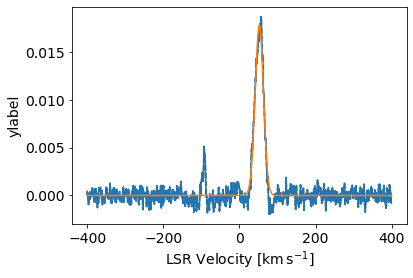

In [ ]:

main()



 VGPS中的源坐标

In [ ]:
from astropy.wcs import WCS
w = WCS('/home/lxwang/data/VGPS_cont_MOS033_new.fits')

px, py = w.wcs_world2pix(34.252, 0.143, 1)
print(px, py)

262.60019063292566 541.5999992041192


 VGPS中源尺寸

In [ ]:
#from astropy.wcs import WCS
w = WCS('/home/lxwang/data/G34.25+0.14_v.-400.0.400.0.moment0.fits')

px, py = w.wcs_pix2world(0, 23, 1)
print(px, py)

0.0 23.0


模拟VGPS源

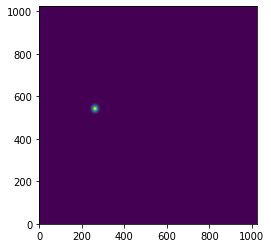

In [ ]:
#import numpy as np
#from astropy.modeling.models import Gaussian2D
y, x = np.mgrid[0:1024, 0:1024]
#data = fits.open('/home/lxwang/data/VGPS_cont_MOS033_new.fits')
data = Gaussian2D(1, 262.6, 541.6, 9, 10, theta= -0.0085)(x, y)

#import matplotlib.pyplot as plt
plt.imshow(data, origin='lower')


OSError: No SIMPLE card found, this file does not appear to be a valid FITS file

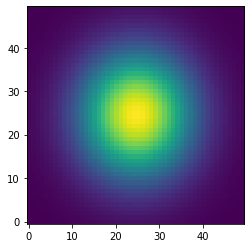

In [ ]:
from astropy.nddata import Cutout2D
from astropy import units as u
from astropy.utils.data import download_file

position = (262.6,541.6)
size = (50,50)    # pixels
cutout = Cutout2D(data, position, size)
plt.imshow(cutout.data, origin='lower')
#plt.savefig('VGPS_cont_MOS033_new-Copy1.png')


def download_image_save_cutout(url, position, size):
    # Download the image
    filename = download_file(url)

    # Load the image and the WCS
    hdu = fits.open(filename)[0]
    wcs = WCS(hdu.header)

    # Make the cutout, including the WCS
    cutout = Cutout2D(hdu.data, position=position, size=size, wcs=wcs)

    # Put the cutout image in the FITS HDU
    hdu.data = cutout.data

    # Update the FITS header with the cutout WCS
    hdu.header.update(cutout.wcs.to_header())

    # Write the cutout to a new FITS file
    cutout_filename = 'example_cutout.fits'
    hdu.writeto(cutout_filename, overwrite=True)


if __name__ == '__main__':
    url = 'http://10.37.0.65:8000/user/lxwang/tree/data/spitzer_example_image.fits'

   # position = (262.6,541.6)
   # size = (50, 50)
    download_image_save_cutout(url, position, size)

(33, 33)
(50, 50)


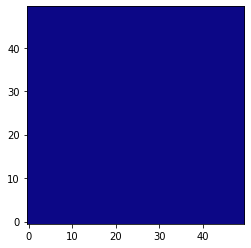

In [ ]:
#import numpy as np
from astropy.io import fits
from astropy import wcs 
from astropy import units as u
from astropy import convolution 
from copy import deepcopy
import matplotlib.pyplot as plt
import sys
import radio_beam

#filein = ('cutout.data')
fileout = ('VGPS_new_2')

#def main(filein,fileout):
beam_size = 4.7/60.0 # deg
beam0 = radio_beam.Beam(1.0/60.0)
beam  = radio_beam.Beam(beam_size)
#======================================================
#hdlist = fits.open(filein)
#hdlist.info()
#image = np.squeeze(hdlist[0].data)  #
image = cutout.data
#header = hdlist[0].header
#hdlist.close()
#wcs0 = wcs.WCS(header)
#======================================================
#pixscale = wcs.utils.proj_plane_pixel_area(wcs0.celestial)**0.5*u.deg #一个pix的大小
pixscale = 1/60*u.deg
convolution_kernel = beam.deconvolve(beam0).as_kernel(pixscale)
print (convolution_kernel.shape)
print (image.shape)
image_new = convolution.convolve_fft(image,convolution_kernel,normalize_kernel=True,allow_huge=True)
#======================================================
hdu = fits.PrimaryHDU(image_new)
#hdu.header = deepcopy(header)
hdu.writeto(fileout,clobber=True)
#======================================================

#fig = plt.figure(figsize=(12,5))
#fig.add_subplot(211)#,projection=wcs0)
plt.imshow(image,cmap='plasma',origin='lower',vmin=3,vmax=12)
#    plt.xlabel('GLON')
#    plt.ylabel('GLat')
#    fig.add_subplot(222)#,projection=wcs0)
#    plt.imshow(image_new,cmap='plasma',origin='lower',vmin=3,vmax=12)
#    plt.xlabel('GLON')
#    plt.ylabel('GLat')

#plt.savefig(fileout,format='eps',dpi=1000)
#plt.show()

#    return 0

MOMENT0 源坐标

In [ ]:
from astropy.wcs import WCS
w = WCS('/home/lxwang/data/G34.25+0.14_v.-400.0.400.0_moment0.fits')

px, py = w.wcs_world2pix(283.34, 1.25, 1)
print(px, py)

22.594859784926424 24.999999999998508


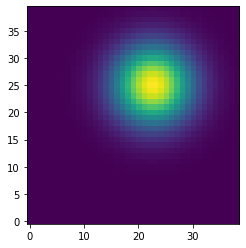

In [ ]:
#import numpy as np
#from astropy.modeling.models import Gaussian2D
y, x = np.mgrid[0:40, 0:39]
#data = fits.open('/home/lxwang/data/G34.25+0.14.fits')
data = Gaussian2D(1, 22.6, 25.0, 5, 5, theta= 0.003)(x, y)

#import matplotlib.pyplot as plt
plt.imshow(data, origin='lower')


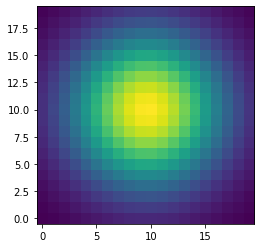

In [ ]:
from astropy.nddata import Cutout2D
from astropy import units as u

position = (22.6,25.0)
size = (20,20)    # pixels
cutout = Cutout2D(data, position, size)
plt.imshow(cutout.data, origin='lower')

moment0中pix转换world

In [ ]:
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
filename = get_pkg_data_filename('/home/lxwang/data/G34.25+0.14_v.-400.0.400.0_moment0.fits')  
hdu = fits.open(filename)[0]  
wcs = WCS(hdu.header)  
wcs  


coord = wcs.pixel_to_world([21],[21])  
coord  

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(283.34992322, 1.2)]>

In [ ]:
import numpy as np
from astropy.io import fits
from astropy import wcs 
from astropy import units as u
from astropy import convolution 
from copy import deepcopy
import matplotlib.pyplot as plt
import sys
import radio_beam

def main('VGPS_cont_MOS033_new-Copy1.png','VGPS_somthing'):
    beam_size = 3.4/60.0 # deg
    beam0 = radio_beam.Beam(1.0/60.0)
    beam  = radio_beam.Beam(beam_size)
#======================================================
    hdlist = fits.open(filein)
    hdlist.info()
    image = np.squeeze(hdlist[0].data)
    header = hdlist[0].header
    hdlist.close()
    wcs0 = wcs.WCS(header)
#======================================================
    pixscale = wcs.utils.proj_plane_pixel_area(wcs0.celestial)**0.5*u.deg
    convolution_kernel = beam.deconvolve(beam0).as_kernel(pixscale)
    print (convolution_kernel.shape)
    print (image.shape)
    image_new = convolution.convolve_fft(image,convolution_kernel,normalize_kernel=True,allow_huge=True)
#======================================================
    hdu = fits.PrimaryHDU(image_new)
    hdu.header = deepcopy(header)
    hdu.writeto(fileout,clobber=True)
#======================================================

#    fig = plt.figure(figsize=(12,5))
#    fig.add_subplot(211)#,projection=wcs0)
#    plt.imshow(image,cmap='plasma',origin='lower',vmin=3,vmax=12)
#    plt.xlabel('GLON')
#    plt.ylabel('GLat')
#    fig.add_subplot(222)#,projection=wcs0)
#    plt.imshow(image_new,cmap='plasma',origin='lower',vmin=3,vmax=12)
#    plt.xlabel('GLON')
#    plt.ylabel('GLat')

#    plt.savefig(fileout,format='eps',dpi=1000)
    plt.show()

SyntaxError: invalid syntax (3969160104.py, line 11)

In [ ]:
import radio_beam
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.convolution import Gaussian1DKernel

cube = SpectralCube.read('/home/lxwang/data/'+'VGPS_cont_MOS033.fits')
kernel = Gaussian1DKernel(2.5)
new_cube = cube.spectral_smooth(kernel)
#plot_keep(new_cube)
#common_beam = cube.beams.common_beam()
#new_cube = cube.convolve_to(common_beam)

In [ ]:
import radio_beam
from spectral_cube import SpectralCube
from astropy import units as u

cube = SpectralCube.read('/home/lxwang/data/'+'VGPS_cont_MOS033.fits')
beam = radio_beam.Beam(major=1*u.arcsec, minor=1*u.arcsec, pa=0*u.deg)
new_cube = cube.convolve_to(beam)

NoBeamError: No beam is defined for this SpectralCube or the beam information could not be parsed from the header. A `~radio_beam.Beam` object can be added using `cube.with_beam`.

In [ ]:
import radio_beam
from spectral_cube import SpectralCube
from astropy import units as u
from astropy.convolution import Gaussian1DKernel

cube = SpectralCube.read('/home/lxwang/data/'+'VGPS_cont_MOS033.fits')
kernel = Gaussian1DKernel(2.5)
new_cube = cube.spectral_smooth(kernel)
new_axis = np.arange(0,10,2)*u.km/u.s
fwhm_factor = np.sqrt(8*np.log(2))

smcube = cube.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
interp_Cube = smcube.spectral_interpolate(new_axis,
                                          suppress_smooth_warning=True)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
